In [8]:
import pandas as pd
import praw
import re
import nltk


import networkx as nx
import gensim.models


import xgboost as xgb
import numba 
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA

import sklearn 
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline, make_union
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import xgboost as xgb

regex = re.compile('[^a-zA-Z ]')

#@numba.jit # unfortunately this doesn't jit easily :(
def tokenize(text):
    # given a body of text, this splits into sentences, then processes each word in the sentence to remove
    # non alphabetical characters... (? bad idea, what about users with numbers in their name)
    # returns it as a list of lists of words, the format desired by gensims word2vec
    
    sentences = []
    if type(text) == str:
        for sentence in nltk.tokenize.sent_tokenize(text):
            processed = [regex.sub('', word.lower()) for word in sentence.split(' ') ]
            processed = [word for word in processed if word not in set( ['' ])]
            sentences.append(processed)
    return sentences

def average_vector(text, model):
    present_keys = [x for x in text if x in model.wv.key_to_index ]
    if not present_keys:
        return np.zeros(model.wv.vector_size)
    return sum( [model.wv[x] for x in present_keys] ) /len(present_keys)

def average_vector_paragraph(text, model):
    if text == []:
        return np.zeros(model.wv.vector_size)
    return sum( average_vector(sentence, model)  for sentence in text )

## Most similar posts?


def similarity(vec_1, vec_2):
    return sklearn.metrics.pairwise.cosine_similarity([vec_1], [vec_2])[0]

def make_similarity_col(df, given_index):
    given_vector = df['avg_vector'][given_index] 
    df['similarity'] = df['avg_vector'].apply( lambda x : similarity(x, given_vector))
    
# helper function for printing the most similar word vectors

def sims(args, model):
    for word, sim in model.wv.most_similar(**args, topn = 10):
        print( f"{word} - similarity {sim}")

def train_w2v(tokenized_text):
    # the train dataframe ot build the w2v model on
    
    corpus = []
    for tokenized in tokenized_text:
        corpus += tokenized

    model = gensim.models.Word2Vec(sentences = corpus,  min_count=10, vector_size=300, epochs = 4)
    #model_fasttext = gensim.models.FastText(sentences = corpus,  min_count=10, vector_size=200, epochs = 4)
    
    return model

  


In [3]:
df = pd.read_csv("../Data/wsb_full_not_deleted_withdt.csv")
df=df.loc[(((df.removed_by_category.isnull()))) & ((df.is_self==True) & (df.num_comments<=10000) & ~(df["title"].str.contains("Thread|thread|Sunday Live Chat|consolidation zone|Containment Zone|Daily Discussion|Daily discussion|Saturday Chat|What Are Your Moves Tomorrow|What Are Your Moves Today|MEGATHREAD",na=False)))]


C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (45,88,117,118,119,122,123,124,125) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
df = df.dropna(subset = ['title', 'selftext'])


In [9]:
df['tokenized_title'] = df.title.apply(tokenize)
df['tokenized_selftext'] = df.selftext.apply(tokenize)

In [ ]:
## Code for making the concept clusters:

if False:
    rough_cluster_size = 200
    
    corpus=df['tokenized_title'].append(df['tokenized_selftext'])
    model = train_w2v(corpus) 

    corpus_df = pd.DataFrame(model.wv.key_to_index.keys())
    corpus_df['vector'] = corpus_df[0].apply(lambda x : model.wv[x])

    X = np.vstack(corpus_df['vector'].to_numpy())
    
    
    model = KMeans(n_clusters= int(len(corpus_df)/rough_cluster_size),verbose=1 )
    model.fit(X)
    corpus_df['prediction'] = model.predict(X)

In [62]:
# TODO: Remove stopwords with spaCy

corpus_df.groupby("prediction").agg('count').sort_values(by = 'vector')

,Unnamed: 0,vector
prediction,,
81,1,1
92,2,2
91,2,2
72,2,2
46,2,2
...,...,...
15,385,385
19,697,697
87,880,880


In [71]:
list(corpus_df [corpus_df.prediction == 55].index)

['fed',
 'debt',
 'capital',
 'government',
 'credit',
 'plan',
 'stimulus',
 'tax',
 'loans',
 'liquidity',
 'unemployment',
 'loan',
 'bill',
 'federal',
 'corporate',
 'bankruptcy',
 'mortgage',
 'taxes',
 'program',
 'agreement',
 'reserve',
 'treasury',
 'payments',
 'fiscal',
 'congress',
 'policy',
 'law',
 'feds',
 'qe',
 'central',
 'funding',
 'administration',
 'senate',
 'repo',
 'package',
 'checks',
 'emergency',
 'cuts',
 'facility',
 'bailout',
 'monetary',
 'relief']

In [10]:
corpus_df = pd.read_csv("word_clusters_nclusters_lendiv200.csv")

In [14]:
corpus_df = corpus_df.set_index('0')
cluster_dictionary = dict(corpus_df['prediction'])

In [15]:
cluster_dictionary

{'the': 3,
 'to': 4,
 'and': 4,
 'a': 82,
 'of': 65,
 'is': 44,
 'in': 57,
 'i': 67,
 'for': 65,
 'this': 22,
 'that': 22,
 'on': 4,
 'you': 67,
 'it': 78,
 'are': 44,
 'with': 65,
 'be': 50,
 'at': 16,
 'have': 33,
 'they': 67,
 'will': 71,
 'but': 22,
 'as': 37,
 'not': 22,
 'if': 22,
 'we': 67,
 'up': 4,
 'my': 41,
 'all': 52,
 'its': 82,
 'from': 35,
 'so': 22,
 'their': 65,
 'or': 22,
 'has': 33,
 'was': 44,
 'market': 21,
 'just': 22,
 'stock': 21,
 'what': 78,
 'by': 35,
 'can': 38,
 'more': 53,
 'out': 4,
 'your': 41,
 'like': 45,
 'about': 69,
 'now': 22,
 'some': 52,
 'an': 95,
 'buy': 90,
 'im': 20,
 'do': 18,
 'gme': 68,
 'going': 46,
 'get': 50,
 'there': 80,
 'dont': 71,
 'money': 34,
 'price': 49,
 'been': 62,
 'when': 4,
 'time': 63,
 'here': 6,
 'shares': 68,
 'me': 41,
 'people': 30,
 'which': 22,
 'how': 92,
 'one': 57,
 'earnings': 75,
 'down': 4,
 'would': 71,
 'short': 68,
 'go': 50,
 'because': 22,
 'no': 22,
 'know': 18,
 'us': 11,
 'only': 57,
 'into': 4,
 'tha

In [ ]:
### Code for creating concept clusters:





In [16]:
def replace_with_cluster_labels(tokenization, corpus_df):
    clusters = []
    for sent in tokenization:
        for token in sent:
            if token in cluster_dictionary:
                clusters.append( cluster_dictionary[token])
    return clusters

def cluster_counter(tokenization, value):
    counter = 0
    for sent in tokenization:
        for token in sent:
            if token in cluster_dictionary:
                if cluster_dictionary[token] == value:
                    counter += 1
    return counter
value_list = list( set(cluster_dictionary.values()))

for value in value_list:
    #print(value)
    df["title_cluster_" + str(value) + "_counts"] = df['tokenized_title'].apply(lambda x : cluster_counter(x, value))
    df["selftext_cluster_" + str(value) + "_counts"] = df['tokenized_selftext'].apply(lambda x : cluster_counter(x, value))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


In [17]:
cols = []

for value in value_list:
    cols.append("title_cluster_" + str(value) + "_counts")
    cols.append("selftext_cluster_" + str(value) + "_counts")
    

working on LinearRegression()


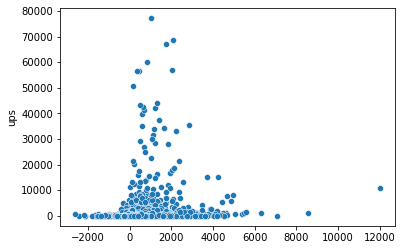

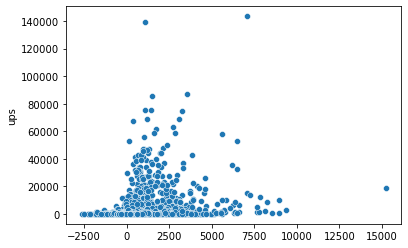

[-0.04540416 -0.26796861 -0.06975051 -0.01889146  0.0127936 ]
working on XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=2, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)


C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


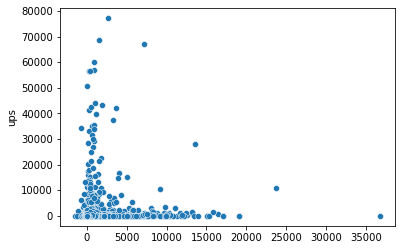

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


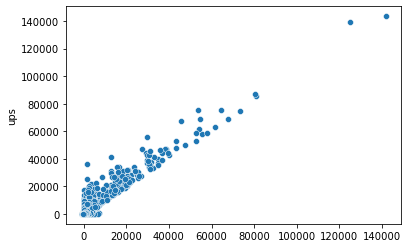

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[-6.92204177e-01 -1.87670647e+00 -6.51524243e-01 -1.17463209e-01
  9.06612506e-04]


C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [18]:
def run_experiment(model, df):
    X = df.drop(columns = ['ups'])
    y = df.ups

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0)

    print("working on", model)

    pipe = make_pipeline( model)
    pipe.fit(X_train, y_train)


    sns.scatterplot(x = pipe.predict(X_test), y = y_test)
    plt.show()
    sns.scatterplot(x = pipe.predict(X_train), y = y_train)
    plt.show()
    
    scores = cross_val_score(pipe,X,y)
    print(scores)

for model in [LinearRegression(), xgb.XGBRegressor(random_state=2)]:
    run_experiment(model, df[cols + ['ups']])


working on XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=2,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


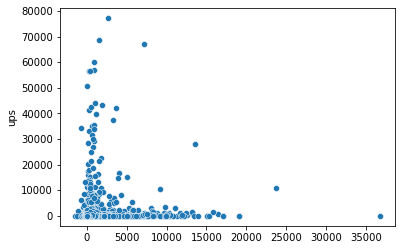

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


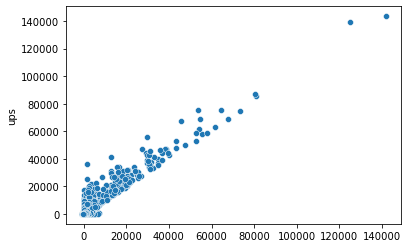

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\env

[-6.92204177e-01 -1.87670647e+00 -6.51524243e-01 -1.17463209e-01
  9.06612506e-04]
working on XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=2,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


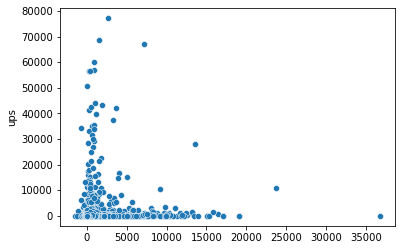

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


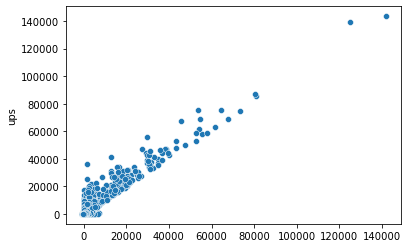

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\env

[-6.92204177e-01 -1.87670647e+00 -6.51524243e-01 -1.17463209e-01
  9.06612506e-04]
working on XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=2,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


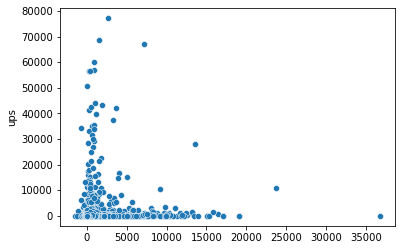

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


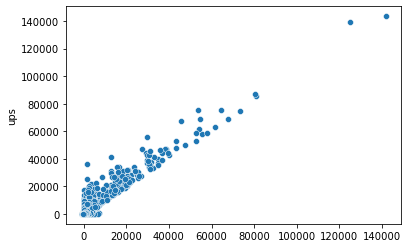

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[-6.92204177e-01 -1.87670647e+00 -6.51524243e-01 -1.17463209e-01
  9.06612506e-04]


C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [19]:

for depth in [2,3,4]:
    
    xgb.XGBRegressor(random_state=2, max_depth = depth, )
    run_experiment(model, df[cols + ['ups']])


working on XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=2,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


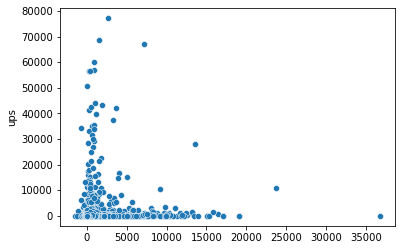

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


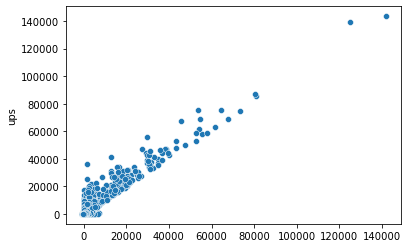

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\lnajt\anaconda3\env

[-6.92204177e-01 -1.87670647e+00 -6.51524243e-01 -1.17463209e-01
  9.06612506e-04]
working on XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=2,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


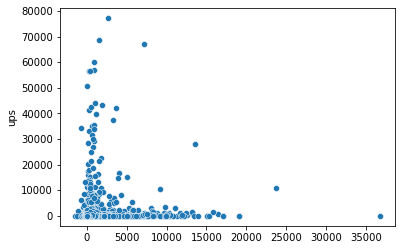

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


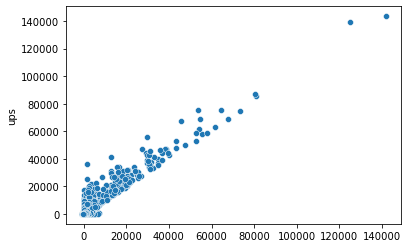

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


KeyboardInterrupt: 

In [20]:
from sklearn.ensemble import RandomForestRegressor

for depth in [2,3,4]:
    
    RandomForestRegressor(random_state=2, max_depth = depth, )
    run_experiment(model, df[cols + ['ups']])

In [50]:


X = df[cols + ['ups']].drop(columns = ['ups'])
Y = df[cols + ['ups']].ups

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0)

eval_set = [(X_test, y_test)]
model = xgb.XGBRegressor(random_state=2, eval_metric="rmse", eval_set=eval_set, verbose=True, max_depth = 1, )


[17:45:20] WARNING: ..\src\learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:2260.91553	validation_1-rmse:2471.32910
[1]	validation_0-rmse:2224.26758	validation_1-rmse:2489.43628
[2]	validation_0-rmse:2197.95606	validation_1-rmse:2502.00244
[3]	validation_0-rmse:2188.12793	validation_1-rmse:2499.34521
[4]	validation_0-rmse:2169.79492	validation_1-rmse:2516.01660
[5]	validation_0-rmse:2163.70166	validation_1-rmse:2514.65820
[6]	validation_0-rmse:2151.00098	validation_1-rmse:2531.71997
[7]	validation_0-rmse:2144.65967	validation_1-rmse:2531.65381
[8]	validation_0-rmse:2135.56909	validation_1-rmse:2559.60181
[9]	validation_0-rmse:2130.27295	validation_1-rmse:2568.80176
[10]	validation_0-rmse:2125.33081	valid

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


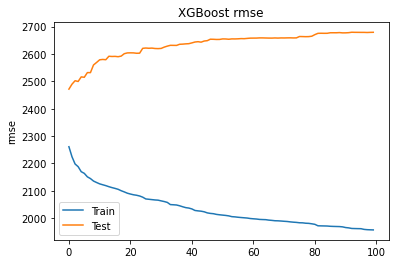

In [51]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot



X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)
# fit model no training data
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["rmse"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# retrieve performance metrics
results = model.evals_result()

epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('rmse')
pyplot.title('XGBoost rmse')
pyplot.show()

In [55]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.utils import to_categorical

In [56]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(28*28,)))

model.add(layers.Dense(16, activation='relu'))

model.add(layers.Dense(10, activation='softmax'))

In [57]:
model.compile(optimizer='rmsprop',
                  loss='rmse',
                  metrics=['rmse'])

In [58]:
X_train_train,X_val,y_train_train,y_val = train_test_split(X, y,
                                                          test_size=.2,
                                                          shuffle=True,
                                                          stratify=y_train,
                                                          random_state=440)

ValueError: Found input variables with inconsistent numbers of samples: [53834, 36068]